In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [3]:
np.random.seed(42)
torch.manual_seed(42)

def generate_data(start, end, delta_x, noise_std=0.02, noise=True):
    x_values = np.arange(start, end, delta_x)
    f_x = np.cos(2 * np.pi * x_values)
    
    if noise:
        f_x_noisy = f_x + np.random.normal(0, noise_std, f_x.shape)
        return x_values, f_x_noisy
    else:
        return x_values, f_x

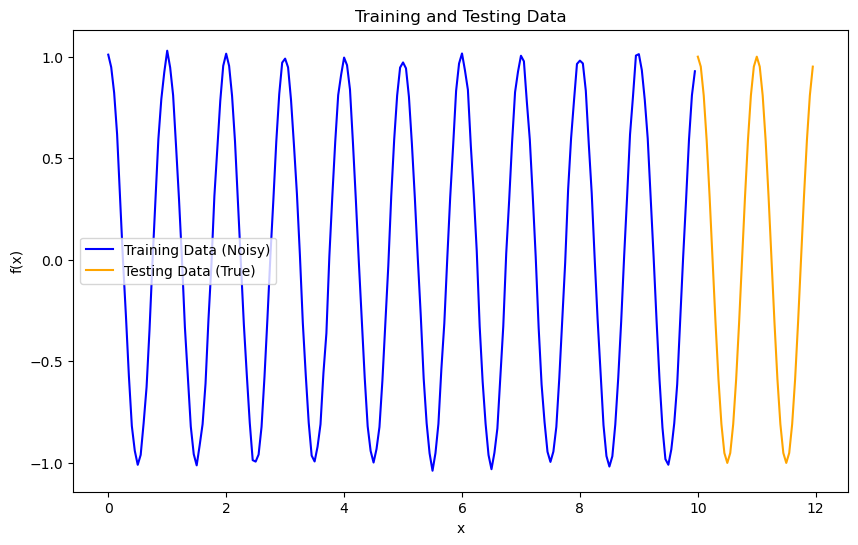

In [4]:
train_start, train_end, delta_x = 0, 10, 0.05
x_train, y_train_noisy = generate_data(train_start, train_end, delta_x)

test_start, test_end = 10, 12
x_test, y_test = generate_data(test_start, test_end, delta_x, noise=False)

plt.figure(figsize=(10, 6))
plt.plot(x_train, y_train_noisy, label='Training Data (Noisy)', color='blue')
plt.plot(x_test, y_test, label='Testing Data (True)', color='orange')
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Training and Testing Data')
plt.show()

In [5]:
def create_sequences(data, sequence_length=10):
    inputs = []
    targets = []
    for i in range(len(data) - sequence_length):
        inputs.append(data[i:(i+sequence_length)])
        targets.append(data[i+sequence_length])
        
    inputs_tensor = torch.tensor(inputs, dtype=torch.float32).unsqueeze(-1)
    targets_tensor = torch.tensor(targets, dtype=torch.float32).unsqueeze(-1)
    
    return inputs_tensor, targets_tensor

In [6]:
sequence_length=10
inputs, targets = create_sequences(y_train_noisy, sequence_length)

/var/folders/y8/wjhjb7xx2r1f3kx5bjky8g700000gn/T/ipykernel_59259/3979050503.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  inputs_tensor = torch.tensor(inputs, dtype=torch.float32).unsqueeze(-1)


In [9]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        
        self.linear = nn.Linear(hidden_layer_size, output_size)
        
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))
        
    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]
        

model = LSTMModel()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

model

LSTMModel(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [11]:
epochs = 150
for epoch in range(epochs):
    for seq, labels in zip(inputs, targets):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(seq)
        
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
        
    if (epoch+1) % 25 == 0:
        print(f'Epoch {epoch + 1} loss: {single_loss.item()}')
        
print(f'Final loss: {single_loss.item()}')

Epoch 25 loss: 0.0008645592606626451
Epoch 50 loss: 0.0003516858851071447
Epoch 75 loss: 0.0003475978155620396
Epoch 100 loss: 0.0003917854046449065
Epoch 125 loss: 0.00044264993630349636
Epoch 150 loss: 0.0004890728741884232
Final loss: 0.0004890728741884232


L2 Relative Error: 0.014594561903886642


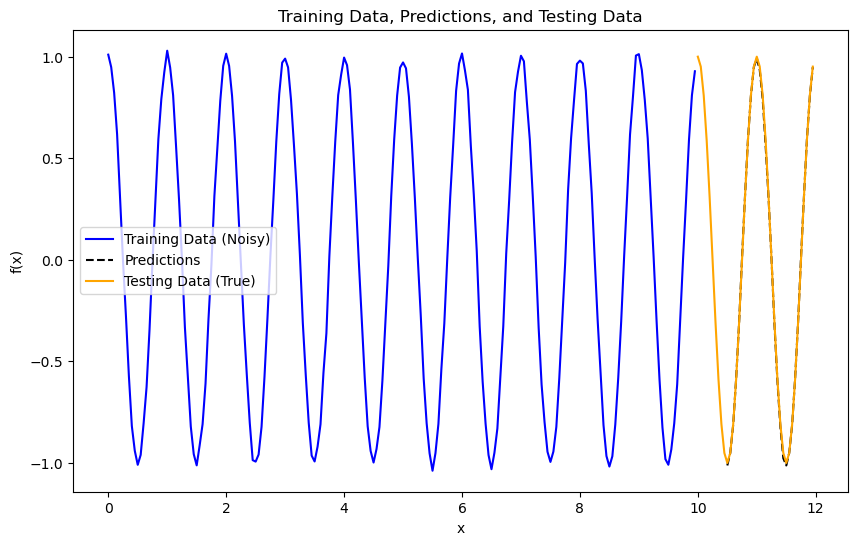

In [13]:
# Step 1: Prepare the testing data as input sequences
def create_test_sequences(data, sequence_length=10):
    sequences = [data[i:(i + sequence_length)] for i in range(len(data) - sequence_length)]
    return torch.tensor(sequences, dtype=torch.float32).unsqueeze(-1)

# Create sequences from the testing data (without noise)
test_sequences = create_test_sequences(y_test)

# Step 2: Make predictions on the testing data
model.eval()  # Set the model to evaluation mode
predictions = []
with torch.no_grad():
    for seq in test_sequences:
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))
        predictions.append(model(seq).item())

# Convert predictions to a numpy array for easier manipulation
predictions = np.array(predictions)

# Step 3: Compute the L2 relative error
def l2_relative_error(N, f):
    return np.linalg.norm(N - f, 2) / np.linalg.norm(f, 2)

# The ground truth for the test sequences is the next value after each sequence
ground_truth = y_test[sequence_length:]
error = l2_relative_error(predictions, ground_truth)
print(f'L2 Relative Error: {error}')

# Step 4: Plot the training data, prediction, and testing data
plt.figure(figsize=(10, 6))
plt.plot(x_train, y_train_noisy, label='Training Data (Noisy)', color='blue')
plt.plot(x_test[sequence_length:], predictions, label='Predictions', color='black', linestyle='--')
plt.plot(x_test, y_test, label='Testing Data (True)', color='orange')
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Training Data, Predictions, and Testing Data')
plt.show()

### Report

